In [1]:
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from visualkeras import layered_view
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist
from tensorflow.keras.layers import Dense, Flatten, UpSampling2D, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152

from gand.data import data
from gand.config import MLConfig
from gand.preprocessing import utils
from gand.visualisation import visualise
from gand.models import models, architecture

import pandas as pd
from tabulate import tabulate
from tqdm.keras import TqdmCallback
from sklearn.metrics import classification_report

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dataset = fashion_mnist
EPOCHS = 100
BATCH_SIZE = MLConfig.BATCH_SIZE

loss = "categorical_crossentropy"
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, momentum=0.9)
metrics = ["accuracy"]

g_model_mnist = load_model(Path.cwd() / 'notebooks/models/cgan/mnist/gen_model_e-200.h5')
g_model_fashion_mnist = load_model(Path.cwd() / 'notebooks/models/cgan/fashion_mnist/E_1000/gen_model_e-536.h5')
g_model_cifar10 = load_model(Path.cwd() / 'notebooks/models/cgan/cifar10/gen_model_e-553.h5')
g_model = g_model_fashion_mnist

In [20]:
MLConfig.TYPE_NAMES = ['normal-ResNet50','gans-ResNet50','imbalanced-ResNet50',
                       'normal-ResNet101','gans-ResNet101','imbalanced-ResNet101',
                       'normal-ResNet152','gans-ResNet152','imbalanced-ResNet152']

# Training

In [5]:
n = 3000 #PER CLASS
X_train_gan, y_train_gan = data.generate_fake_data(n=n, g_model=g_model, seed=10)
X_train_gan, y_train_gan = utils.preprocess_data(X_train_gan, y_train_gan, val_255=False, exp_dims=False)
print(X_train_gan.shape, y_train_gan.shape)

X_train_gan = tf.image.resize(np.repeat(X_train_gan, 3, axis=-1), [32, 32])

print(X_train_gan.shape, y_train_gan.shape)

938/938 [==============================] - 39s 42ms/step
(30000, 28, 28, 1) (30000, 10)
(30000, 32, 32, 3) (30000, 10)


In [17]:
EXP_DIMS = True

((X_train_real, y_train_real), (X_test_real, y_test_real)), dataset_name = data.load_dataset(dataset, return_name=True)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)


# remove_train = X_train_real.shape[0] // (2 * 10) # 3000

# X_train_removed, y_train_removed = [], []

# for i in range(10):
#     class_idx = np.where(X_train_real == i)[0]
#     selected_idx = np.random.choice(class_idx, remove_train)
#     X_train_removed.append(X_train_real[selected_idx])
#     y_train_removed.append(y_train_real[selected_idx])

# X_train_real, y_train_real = np.concatenate(X_train_removed, axis=0), np.concatenate(y_train_removed, axis=0)


X_train_real, y_train_real = utils.preprocess_data(X_train_real, y_train_real, exp_dims=EXP_DIMS)
X_test_real, y_test_real = utils.preprocess_data(X_test_real, y_test_real, exp_dims=EXP_DIMS)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

X_train_real = tf.image.resize(np.repeat(X_train_real, 3, axis=-1), [32, 32])
X_test_real = tf.image.resize(np.repeat(X_test_real, 3, axis=-1), [32, 32])
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) fashion_mnist
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10) fashion_mnist
(60000, 32, 32, 3) (60000, 10) (10000, 32, 32, 3) (10000, 10) fashion_mnist


In [7]:
X_train_real = np.concatenate((X_train_real, X_train_gan), axis=0)
y_train_real = np.concatenate((y_train_real, y_train_gan), axis=0)

X_test_real = np.asarray(X_test_real)
y_test_real = np.asarray(y_test_real)

print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

(60000, 32, 32, 3) (60000, 10) (10000, 32, 32, 3) (10000, 10) fashion_mnist


In [8]:
X_train_real, y_train_real = shuffle(X_train_real, y_train_real)
X_test_real, y_test_real = shuffle(X_test_real, y_test_real)
print(X_train_real.shape, y_train_real.shape, X_test_real.shape, y_test_real.shape, dataset_name)

(60000, 32, 32, 3) (60000, 10) (10000, 32, 32, 3) (10000, 10) fashion_mnist


In [9]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_real, y_train_real))
test_data = tf.data.Dataset.from_tensor_slices((X_test_real, y_test_real))

train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_data, test_data, dataset_name

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 'fashion_mnist')

In [29]:
train_type = 7
MLConfig.TYPE_NAMES[train_type]

'gans-ResNet152'

In [11]:
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet_model.trainable = False

model = Sequential([
    resnet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
], name='ResNet152')

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [12]:
history = model.fit(train_data, batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, validation_data=test_data, verbose=0, 
                    callbacks=[TqdmCallback(verbose=1)], shuffle=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [13]:
eval_data = ((X_train_real, y_train_real), (X_test_real, y_test_real))
models.save_metrics(dataset_name=dataset_name, train_type=train_type,
                   epochs=EPOCHS, model=model, eval_data=eval_data, 
                   history=history)

In [14]:
history_path = Path.cwd() / f'reports/history/{dataset_name}/{MLConfig.TYPE_NAMES[train_type]}/E_{EPOCHS:03d}/'
history_path.mkdir(parents=True, exist_ok=True)
pd.DataFrame.from_dict(history.history).to_csv(history_path / f'{model.name}.csv',index=False)

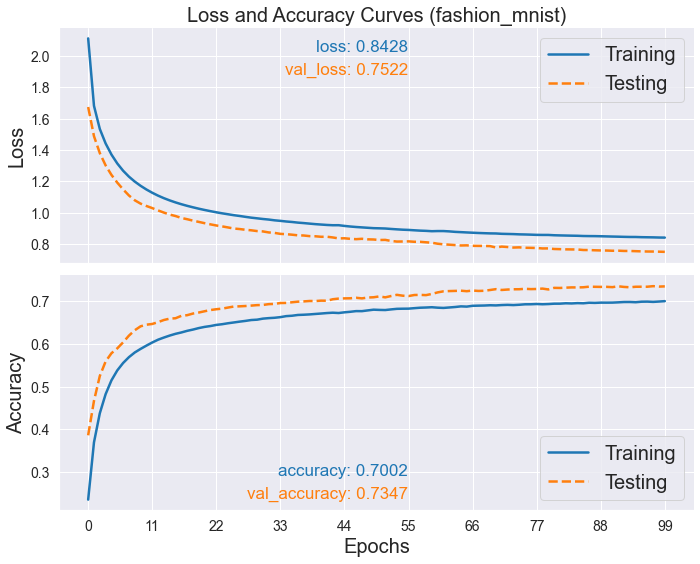

In [15]:
visualise.metric_plot(show_fig=True, history=history, dataset_name=dataset_name, 
                      savefig=False, epochs=EPOCHS)

In [18]:
_, acc = model.evaluate(X_train_real, y_train_real)
_, acc = model.evaluate(X_test_real, y_test_real)

y_pred = np.argmax(model.predict(X_train_real), axis=-1)
report = classification_report(np.argmax(y_train_real, axis=1), y_pred)
print(report)

y_pred = np.argmax(model.predict(X_test_real), axis=-1)
report = classification_report(np.argmax(y_test_real, axis=1), y_pred)
print(report)

1875/1875 [==============================] - 48s 26ms/step
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6000
           1       0.94      0.91      0.92      6000
           2       0.61      0.46      0.53      6000
           3       0.70      0.74      0.72      6000
           4       0.57      0.72      0.64      6000
           5       0.90      0.80      0.85      6000
           6       0.37      0.34      0.35      6000
           7       0.79      0.91      0.85      6000
           8       0.91      0.84      0.87      6000
           9       0.91      0.89      0.90      6000

    accuracy                           0.74     60000
   macro avg       0.74      0.74      0.74     60000
weighted avg       0.74      0.74      0.74     60000

313/313 [==============================] - 9s 27ms/step
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1000
           1     